In [0]:
####    Importing Our Dependencies   ####
%matplotlib inline
import numpy as np 
import tensorflow as tf
import pandas as pd
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils import to_categorical

## **Downloading Our Dataset** 

In [8]:
(XTrain,YTrain),(XTest,YTest) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


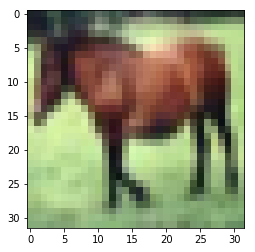

In [18]:
plt.imshow(XTrain[7])
plt.show()

## **More about the cifar10 dataset**

The CIFAR-10 dataset consists of 10 object classes dogs, cats, aeroplanes, automobile, deer, horse, ship, truck, frog, bird. 

The dataset contains coloured images of dimensions 32 x 32. As the documentation states that the data files contains numpy arrays of (10000 * 3072) in row major order 32 height x 32 width x 3 channels RGB = 3072.

There are 10000 images per data_batch = 50000 train images 10000 test images. The first 1024 channels are for red channel ,next for green channel and then blue.

We will require the labels to be one-hot encoded and the images require to be normalized.

### The Labels

The original order of the data labels are:

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck

## Reshaping the data

The reshaping will be done in two steps:

First we will use the numpy.reshape() to shape our images and using the np.traspose() function.

First we will convert the row vector 3072 into 3 x 1024, as per the channel.
Secondly, we will convert it to 3 x 32 x 32 by dividing the tensor resulting from the first reshape by 32 where 32 is the width of the image because of the row major order.
The reshape function will be called with parameters, (10000, 3, 32, 32).

Now, the data is represented as (num_channel , width , height) form. But tensorflow and matplotlib expect a different shape. They expect (width , height , num_channel) instead. We need to swap the order using the transpose.

The transpose function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

In [0]:
def batch(X,Y,size):
  random_indices = np.random.randint(np.size(Y[:,0]),size = (size,1))
  x_batch = X[random_indices]
  x_batch = x_batch.reshape(size,32,32,3)
  y_batch = Y[random_indices]
  y_batch = y_batch.reshape(size, 10)

  return x_batch,y_batch

## Building the Network

In [4]:
# Removing the previous weights, biases, inputs from memory

tf.reset_default_graph()

# #Input
x = tf.placeholder(tf.float32,[None,32,32,3])
y = tf.placeholder(tf.float32,[None,10])

w1  = tf.get_variable('w1',[5,5,3,100],initializer = tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable('w2',[3,3,100,100],initializer = tf.contrib.layers.xavier_initializer())


W0810 10:52:47.055202 140261140313984 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [23]:
with tf.device('/device:GPU:0'):
  cv1 = tf.nn.conv2d(x,w1,strides = [1,1,1,1],padding = 'SAME')
  l1out = tf.nn.relu(cv1)
  l1out = tf.nn.max_pool(l1out,ksize = [1,2,2,1],padding  = 'SAME',strides = [1,2,2,1])
  # l1out = tf.nn.dropout(l1out,0.9)

  cv2 = tf.nn.conv2d(l1out,w2,strides = [1,2,2,1],padding = 'SAME')
  l2out = tf.nn.relu(cv2)
  l2out = tf.nn.max_pool(l2out,ksize = [1,2,2,1],padding = 'SAME',strides = [1,2,2,1])
  # l2out = tf.nn.dropout(l2out,0.9)

  flat_0 = tf.contrib.layers.flatten(l2out)
  flat_1 = tf.layers.dense(flat_0,256,activation = 'relu')
  classifier = tf.layers.dense(flat_1,10,activation = tf.nn.softmax)

  # Loss function and Optimization
  cost = tf.reduce_mean(tf.square(tf.nn.sigmoid(classifier)-y))
  Optimizer = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(cost)

print("Summary:")
print("Data_Shape:",x.shape)
print("cv1 Shape:",cv1.shape)
print("l1out Shape:",l1out.shape)
print("cv2 Shape:",cv2.shape)
print("l2out Shape: ",l2out.shape)
print('flat_0 Shape:',flat_0.shape)
print("flat_1 Shape:",flat_1.shape)
print("Final Shape:",classifier.shape)

Summary:
Data_Shape: (?, 32, 32, 3)
cv1 Shape: (?, 32, 32, 100)
l1out Shape: (?, 16, 16, 100)
cv2 Shape: (?, 8, 8, 100)
l2out Shape:  (?, 4, 4, 100)
flat_0 Shape: (?, 1600)
flat_1 Shape: (?, 256)
Final Shape: (?, 10)


In [30]:
from IPython.display import clear_output

S = tf.Session(config = tf.ConfigProto(log_device_placement = True))
init = tf.global_variables_initializer()
S.run(init)

loss = []

for i in range(200):
  XBatch,YBatch = batch(XTrain, to_categorical(YTrain, num_classes = 10),size = 1000)
  fd = {x:XBatch,y:YBatch}
  S.run(minimize_this,feed_dict = fd)
  clear_output(True) 
  print("Iter: ",i, "Cost: ",S.run(cost,feed_dict = fd))
  loss.append(S.run(cost,feed_dict = fd))

Iter:  199 Cost:  0.2720163


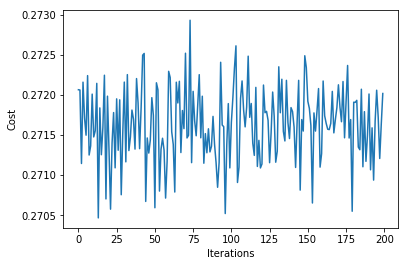

In [31]:
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

In [32]:
# Accuracy

predictions = np.argmax(S.run(classifier,feed_dict = {x:XTest,y:to_categorical(YTest, num_classes = 10)}),axis = 1)
from sklearn.metrics import accuracy_score
print("Accuracy: ",accuracy_score(predictions,YTest)*100,"%")

Accuracy:  14.13 %
